# 1. Hurst & Entropy

In [1]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv("../data/vn30/volume.csv")

In [ ]:
import numpy as np
from scipy.stats import entropy
from hurst import compute_Hc
import antropy as ant

# Lấy tất cả các cột chứng khoán (loại trừ cột 'time')
stock_columns = [col for col in df.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        # Lấy dữ liệu cho cổ phiếu hiện tại và loại bỏ giá trị NaN
        data = df[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi log(0)
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính chỉ số Hurst
            H, c, data_hurst = compute_Hc(data_no_zeros, kind='price', simplified=True)
            
            # Tính Approximate Entropy (ApEn)
            ApEn = ant.app_entropy(data_no_zeros, order=2)
            
            # Tính Sample Entropy (SampEn)
            SampEn = ant.sample_entropy(data_no_zeros, order=2)
            
            # Tính Permutation Entropy
            PermEn = ant.perm_entropy(data_no_zeros, order=3, normalize=True)
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Hurst Exponent": H,
                "Approximate Entropy": ApEn,
                "Sample Entropy": SampEn,
                "Permutation Entropy": PermEn
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Chuyển đổi kết quả thành DataFrame để phân tích dễ dàng hơn
results_df = pd.DataFrame(results)

# Sắp xếp theo tên cổ phiếu để dễ đọc
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính toán thống kê để đưa ra insights
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả cho từng cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân nhóm cổ phiếu theo đặc tính Hurst
hurst_groups = {
    "Random Walk (0.45 < H < 0.55)": results_df[(results_df["Hurst Exponent"] > 0.45) & (results_df["Hurst Exponent"] < 0.55)]["Stock"].tolist(),
    "Anti-persistent (H ≤ 0.45)": results_df[results_df["Hurst Exponent"] <= 0.45]["Stock"].tolist(),
    "Persistent (H ≥ 0.55)": results_df[results_df["Hurst Exponent"] >= 0.55]["Stock"].tolist()
}

print("\nPhân tích dựa trên chỉ số Hurst:")
for category, stocks in hurst_groups.items():
    print(f"{category}: {', '.join(stocks) if stocks else 'Không có'}")

# Xác định cổ phiếu có giá trị entropy cao nhất/thấp nhất
print("\nCổ phiếu có giá trị entropy đặc biệt:")
metrics = ["Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
for metric in metrics:
    highest = results_df.loc[results_df[metric].idxmax()]
    lowest = results_df.loc[results_df[metric].idxmin()]
    print(f"Cao nhất {metric}: {highest['Stock']} ({highest[metric]:.4f})")
    print(f"Thấp nhất {metric}: {lowest['Stock']} ({lowest[metric]:.4f})")

# Phân tích tổng quan thị trường
avg_hurst = stats_df.loc["Mean", "Hurst Exponent"]
print("\nPhân tích tổng quan thị trường:")
if avg_hurst > 0.55:
    print(f"- Thị trường thể hiện xu hướng bền vững (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có xu hướng")
elif avg_hurst < 0.45:
    print(f"- Thị trường thể hiện xu hướng đảo chiều về giá trị trung bình (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có tính quay về giá trị trung bình")
else:
    print(f"- Thị trường thể hiện đặc tính đi ngẫu nhiên (Hurst trung bình = {avg_hurst:.4f}), gợi ý định giá hiệu quả")

# Tương quan giữa các chỉ số
correlation = results_df.iloc[:, 1:].corr()
print("\nTương quan giữa các chỉ số:")
print(correlation.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân tích thêm dựa trên các chỉ số entropy
avg_apen = stats_df.loc["Mean", "Approximate Entropy"]
avg_sampen = stats_df.loc["Mean", "Sample Entropy"]
avg_permen = stats_df.loc["Mean", "Permutation Entropy"]

print("\nPhân tích thêm:")
print(f"- Approximate Entropy trung bình: {avg_apen:.4f}")
print(f"- Sample Entropy trung bình: {avg_sampen:.4f}")
print(f"- Permutation Entropy trung bình: {avg_permen:.4f}")
print("- Giá trị entropy cao hơn chỉ ra tính ngẫu nhiên nhiều hơn và khả năng dự đoán thấp hơn")
print("- Giá trị entropy thấp hơn chỉ ra cấu trúc nhiều hơn và khả năng dự đoán cao hơn")

# Xác định các mẫu đáng chú ý hoặc ngoại lệ
outliers = []
for metric in ["Hurst Exponent", "Approximate Entropy", "Sample Entropy", "Permutation Entropy"]:
    mean = stats_df.loc["Mean", metric]
    std = stats_df.loc["Std", metric]
    high_outliers = results_df[results_df[metric] > mean + 2*std]["Stock"].tolist()
    low_outliers = results_df[results_df[metric] < mean - 2*std]["Stock"].tolist()
    
    if high_outliers:
        outliers.append(f"Cao bất thường trong {metric}: {', '.join(high_outliers)}")
    if low_outliers:
        outliers.append(f"Thấp bất thường trong {metric}: {', '.join(low_outliers)}")

if outliers:
    print("\nCác ngoại lệ đáng chú ý (vượt quá 2 độ lệch chuẩn):")
    for outlier in outliers:
        print(f"- {outlier}")

Kết quả cho từng cổ phiếu:
Stock  Hurst Exponent  Approximate Entropy  Sample Entropy  Permutation Entropy
  ACB          0.5779               1.3355          1.1502               0.9984
  BCM          2.3999               0.7482          0.3000               0.9989
  BID          0.7103               1.3289          1.2001               0.9954
  BVH          0.6650               1.3424          1.0356               0.9975
  CTG          0.5807               1.2670          1.0790               0.9950
  FPT          0.6371               1.2496          1.1057               0.9972
  GAS          0.6672               1.3104          1.1309               0.9967
  GVR          0.6400               1.3499          1.1798               0.9985
  HDB          0.6894               1.1710          0.8753               0.9935
  HPG          0.5869               1.5161          1.5732               0.9978
  LPB          1.0846               1.3077          1.0060               0.9947
  MBB        

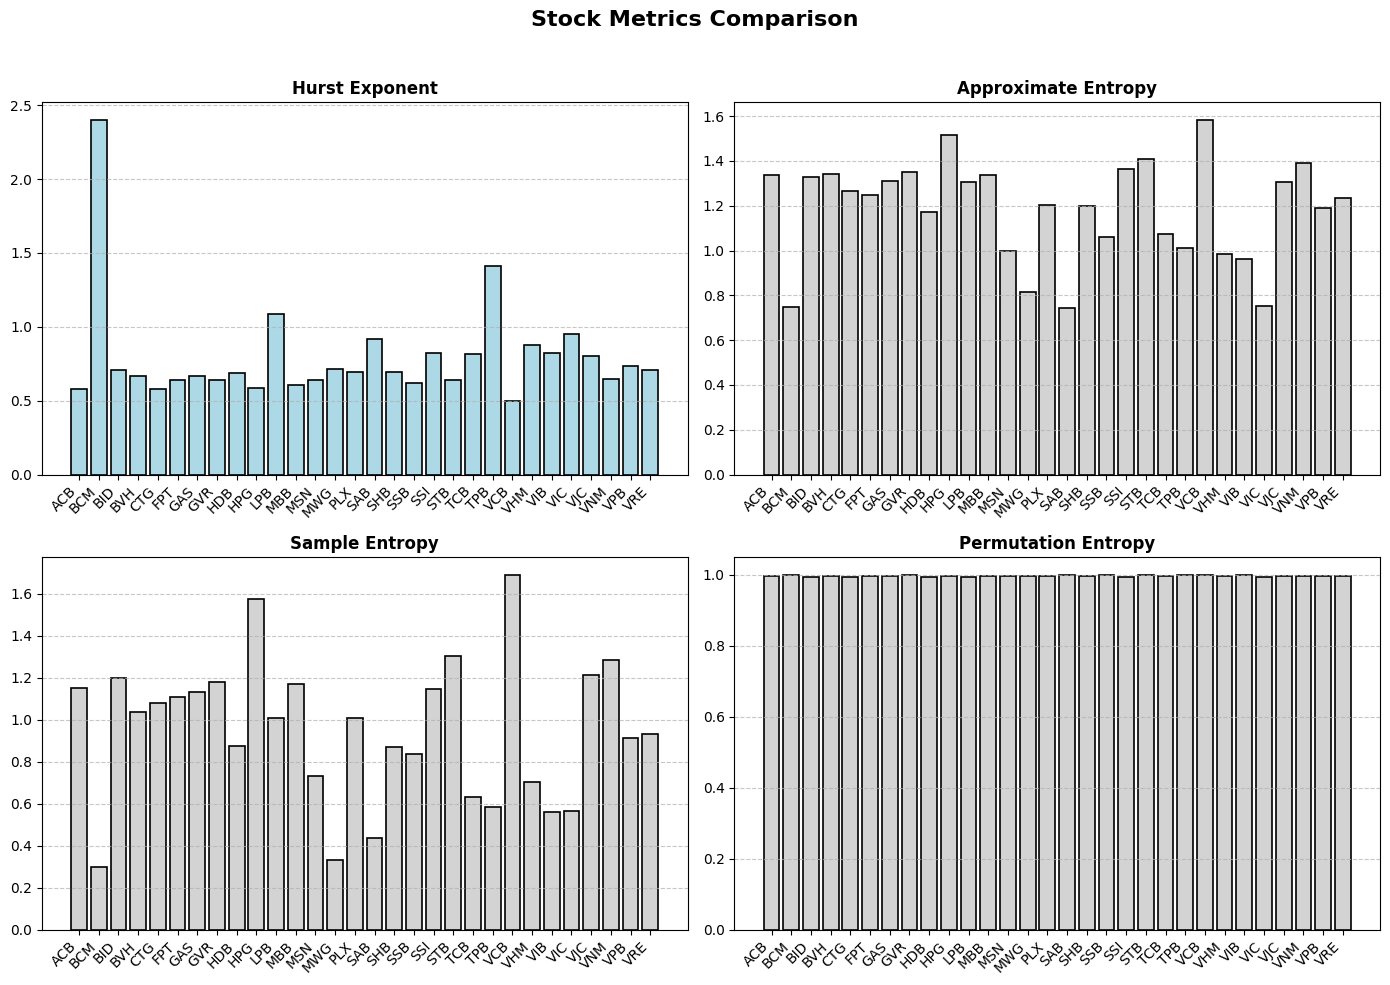

In [10]:
# Tạo lại DataFrame từ dữ liệu cung cấp
import pandas as pd
import matplotlib.pyplot as plt

data_dict = {
    "Stock": ["ACB", "BCM", "BID", "BVH", "CTG", "FPT", "GAS", "GVR", "HDB", "HPG",
              "LPB", "MBB", "MSN", "MWG", "PLX", "SAB", "SHB", "SSB", "SSI", "STB",
              "TCB", "TPB", "VCB", "VHM", "VIB", "VIC", "VJC", "VNM", "VPB", "VRE"],
    "Hurst Exponent": [0.5779, 2.3999, 0.7103, 0.6650, 0.5807, 0.6371, 0.6672, 0.6400, 0.6894, 0.5869,
                       1.0846, 0.6081, 0.6416, 0.7158, 0.6933, 0.9177, 0.6964, 0.6169, 0.8219, 0.6435,
                       0.8140, 1.4137, 0.5006, 0.8770, 0.8250, 0.9510, 0.8058, 0.6470, 0.7363, 0.7091],
    "Approximate Entropy": [1.3355, 0.7482, 1.3289, 1.3424, 1.2670, 1.2496, 1.3104, 1.3499, 1.1710, 1.5161,
                            1.3077, 1.3352, 0.9987, 0.8172, 1.2034, 0.7450, 1.1994, 1.0622, 1.3658, 1.4092,
                            1.0726, 1.0110, 1.5825, 0.9829, 0.9636, 0.7530, 1.3050, 1.3916, 1.1894, 1.2349],
    "Sample Entropy": [1.1502, 0.3000, 1.2001, 1.0356, 1.0790, 1.1057, 1.1309, 1.1798, 0.8753, 1.5732,
                       1.0060, 1.1691, 0.7318, 0.3320, 1.0097, 0.4382, 0.8693, 0.8342, 1.1460, 1.3025,
                       0.6298, 0.5814, 1.6882, 0.7032, 0.5622, 0.5636, 1.2102, 1.2833, 0.9115, 0.9313],
    "Permutation Entropy": [0.9984, 0.9989, 0.9954, 0.9975, 0.9950, 0.9972, 0.9967, 0.9985, 0.9935, 0.9978,
                            0.9947, 0.9981, 0.9968, 0.9984, 0.9963, 0.9987, 0.9966, 0.9987, 0.9956, 0.9987,
                            0.9973, 0.9997, 0.9986, 0.9968, 0.9988, 0.9952, 0.9963, 0.9984, 0.9984, 0.9984]
}

df_metrics = pd.DataFrame(data_dict)

# Vẽ 4 biểu đồ subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["Hurst Exponent", "Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
colors = ["lightblue", "lightgray", "lightgray", "lightgray"]  # Hurst màu xanh nhạt, còn lại xám

# Vẽ từng biểu đồ
for ax, metric, color in zip(axes.flatten(), metrics, colors):
    ax.bar(df_metrics["Stock"], df_metrics[metric], color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Tiêu đề chính cho toàn bộ subplot
fig.suptitle("Stock Metrics Comparison", fontsize=16, fontweight="bold")

# Tăng khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Hiển thị biểu đồ
plt.show()


In [11]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import antropy as ant

# Lấy tất cả các cột chứng khoán (loại trừ cột 'time')
stock_columns = [col for col in df.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

# Hàm tính Recurrence Rate (RR)
def compute_rr(data, threshold=0.1):
    """Tính tỷ lệ tái phát"""
    data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))
    n = len(data_norm)
    count = 0
    for i in range(n):
        for j in range(i, n):  # Chỉ tính nửa trên của ma trận để tăng tốc
            if abs(data_norm[i] - data_norm[j]) < threshold:
                count += 1
    count = 2 * count - n  # Nhân đôi kết quả trừ đi đường chéo
    return count / (n * n)

# Hàm tính Determinism (DET)
def compute_det(data, threshold=0.1):
    """Tính độ quyết định"""
    n = len(data)
    if n <= 1:
        return 0
    autocorr = np.correlate(data, data, mode='full')[n-1:] / (n * np.var(data))
    det_points = np.sum(autocorr > threshold)
    return det_points / len(autocorr)

# Hàm tính Laminarity (LAM)
def compute_lam(data, threshold=0.1):
    """Tính độ trầm"""
    n = len(data)
    if n <= 1:
        return 0
    changes = np.abs(np.diff(data)) / np.std(data)
    lam_points = np.sum(changes < threshold)
    return lam_points / (n - 1)

# Hàm tính Trapping Time (TT)
def compute_tt(data, threshold=0.1):
    """Tính thời gian bẫy"""
    n = len(data)
    if n <= 1:
        return 0
    changes = np.abs(np.diff(data)) / np.std(data)
    is_trapped = changes < threshold
    
    trapped_segments = []
    current_segment = 0
    for trapped in is_trapped:
        if trapped:
            current_segment += 1
        else:
            if current_segment > 0:
                trapped_segments.append(current_segment)
                current_segment = 0
    if current_segment > 0:
        trapped_segments.append(current_segment)
    
    return np.mean(trapped_segments) if trapped_segments else 0

# Hàm tính Shannon Entropy
def compute_shannon(data, bins=20):
    """Tính Shannon Entropy"""
    hist, _ = np.histogram(data, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

# Hàm tính KS Entropy
def compute_ks_entropy(data):
    """Tính Kolmogorov-Sinai Entropy"""
    try:
        e1 = ant.sample_entropy(data, order=2)
        e2 = ant.sample_entropy(data, order=3)
        return max(0, e2 - e1)
    except:
        return np.nan

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        data = df[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi log(0)
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính các chỉ số
            rr = compute_rr(data_no_zeros)
            det = compute_det(data_no_zeros)
            lam = compute_lam(data_no_zeros)
            tt = compute_tt(data_no_zeros)
            shannon_ent = compute_shannon(data_no_zeros)
            ks_ent = compute_ks_entropy(data_no_zeros)
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Recurrence Rate (RR)": rr,
                "Determinism (DET)": det,
                "Laminarity (LAM)": lam,
                "Trapping Time (TT)": tt,
                "Shannon Entropy": shannon_ent,
                "KS Entropy": ks_ent
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Tạo DataFrame kết quả và sắp xếp
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính các thống kê cơ bản
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả các chỉ số theo cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

Kết quả các chỉ số theo cổ phiếu:
Stock  Recurrence Rate (RR)  Determinism (DET)  Laminarity (LAM)  Trapping Time (TT)  Shannon Entropy  KS Entropy
  ACB                0.5016             0.9277            0.1793              1.3938           2.1692      0.0000
  BCM                0.5565             0.6597            0.4404              3.0559           1.8083      0.0000
  BID                0.6598             0.9352            0.1657              1.4577           1.8414      0.0000
  BVH                0.4813             0.8736            0.1721              1.3961           2.1960      0.0000
  CTG                0.4488             0.9432            0.1777              1.3962           2.2961      0.0000
  FPT                0.5723             0.9584            0.1825              1.4340           2.0253      0.0000
  GAS                0.5254             0.9192            0.1801              1.3720           2.1241      0.0000
  GVR                0.4852             0.8810        

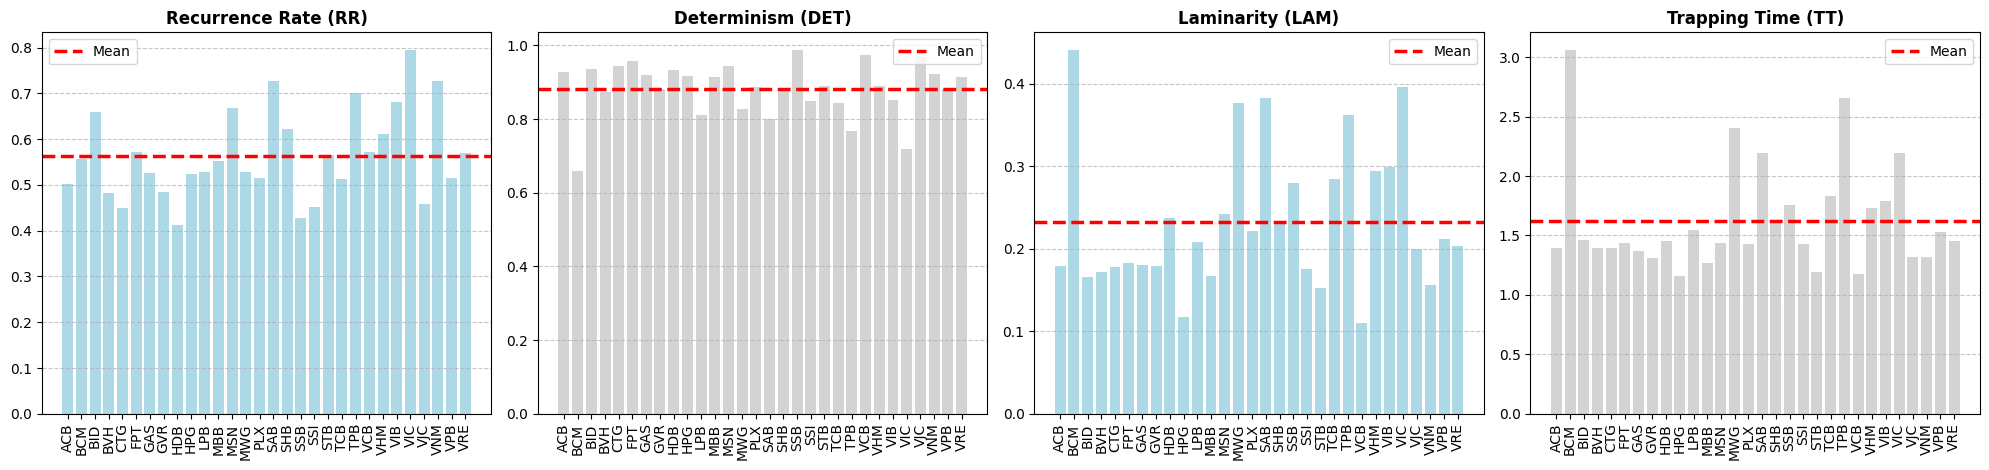

In [ ]:
# Tạo lại DataFrame từ dữ liệu cung cấp
import numpy as np

data_dict = {
    "Stock": ["ACB", "BCM", "BID", "BVH", "CTG", "FPT", "GAS", "GVR", "HDB", "HPG",
              "LPB", "MBB", "MSN", "MWG", "PLX", "SAB", "SHB", "SSB", "SSI", "STB",
              "TCB", "TPB", "VCB", "VHM", "VIB", "VIC", "VJC", "VNM", "VPB", "VRE"],
    "Recurrence Rate (RR)": [0.5016, 0.5565, 0.6598, 0.4813, 0.4488, 0.5723, 0.5254, 0.4852, 0.4129, 0.5240,
                             0.5273, 0.5528, 0.6675, 0.5276, 0.5157, 0.7259, 0.6223, 0.4275, 0.4523, 0.5643,
                             0.5133, 0.7010, 0.5729, 0.6102, 0.6818, 0.7936, 0.4588, 0.7265, 0.5143, 0.5687],
    "Determinism (DET)": [0.9277, 0.6597, 0.9352, 0.8736, 0.9432, 0.9584, 0.9192, 0.8810, 0.9336, 0.9176,
                          0.8113, 0.9144, 0.9448, 0.8272, 0.8880, 0.8016, 0.8781, 0.9863, 0.8504, 0.8888,
                          0.8424, 0.7680, 0.9736, 0.8912, 0.8528, 0.7176, 0.9688, 0.9216, 0.8824, 0.9152],
    "Laminarity (LAM)": [0.1793, 0.4404, 0.1657, 0.1721, 0.1777, 0.1825, 0.1801, 0.1786, 0.2370, 0.1177,
                         0.2082, 0.1673, 0.2418, 0.3771, 0.2218, 0.3827, 0.2303, 0.2794, 0.1761, 0.1521,
                         0.2842, 0.3619, 0.1105, 0.2946, 0.2995, 0.3963, 0.2002, 0.1561, 0.2122, 0.2034],
    "Trapping Time (TT)": [1.3938, 3.0559, 1.4577, 1.3961, 1.3962, 1.4340, 1.3720, 1.3136, 1.4510, 1.1575,
                           1.5449, 1.2667, 1.4381, 2.4031, 1.4278, 2.1927, 1.6307, 1.7600, 1.4286, 1.1950,
                           1.8299, 2.6588, 1.1795, 1.7277, 1.7885, 2.1903, 1.3158, 1.3176, 1.5318, 1.4514]
}

df_metrics = pd.DataFrame(data_dict)

# Tính giá trị trung bình cho từng chỉ số
mean_values = df_metrics.mean(numeric_only=True)

# Vẽ 4 biểu đồ subplot trên cùng một hàng
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

metrics = ["Recurrence Rate (RR)", "Determinism (DET)", "Laminarity (LAM)", "Trapping Time (TT)"]
colors = ["lightblue", "lightgray", "lightblue", "lightgray"]  # Áp dụng màu sắc yêu cầu

# Vẽ từng biểu đồ
for ax, metric, color in zip(axes, metrics, colors):
    ax.bar(df_metrics["Stock"], df_metrics[metric], color=color, edgecolor='black', linewidth=0)
    ax.axhline(mean_values[metric], color='red', linestyle="--", linewidth=2.5, label="Mean")  # Đường trung bình
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=90, ha="center")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

# Tăng khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Hiển thị biểu đồ
plt.show()
